# Building a Euribor Curve - Interpolation Analysis - Simple Case

We build an Ibor single-curve and examine different interpolation choices for a simple curve.

This follows:

https://quant.stackexchange.com/questions/53904/monotonic-cubic-spline-interpolation-quantlib-python?rq=1

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
from financepy.finutils import *
from financepy.products.rates import *

In [13]:
valuationDate = TuringDate(12, 5, 2020)

## Building the Single Curve

Build the Ibor Curve

In [14]:
cal = TuringCalendarTypes.TARGET

depoDCCType = TuringDayCountTypes.ACT_360
depos = []
spotDays = 0
settlementDate = valuationDate.addWeekDays(spotDays)
depo = TuringIborDeposit(settlementDate, "6M", -0.114/100.0, depoDCCType, calendarType=cal); depos.append(depo)
fraDCCType = TuringDayCountTypes.ACT_360

fras = []
fra = TuringIborFRA(settlementDate.addTenor("6M"), "6M", -0.252/100.0, fraDCCType, calendarType=cal); fras.append(fra)
fra = TuringIborFRA(settlementDate.addTenor("12M"), "6M", -0.306/100.0, fraDCCType, calendarType=cal); fras.append(fra)

swaps = []
swapType = TuringSwapTypes.PAY
fixedDCCType = TuringDayCountTypes.THIRTY_E_360_ISDA
fixedFreqType = TuringFrequencyTypes.ANNUAL

swap = TuringIborSwap(settlementDate, "2Y", swapType, -0.325/100.0, fixedFreqType, fixedDCCType, calendarType=cal); swaps.append(swap)
swap = TuringIborSwap(settlementDate, "3Y", swapType, -0.347/100.0, fixedFreqType, fixedDCCType, calendarType=cal); swaps.append(swap)

iborDepos = depos.copy()
iborFras = fras.copy()
iborSwaps = swaps.copy()

In [15]:
iborCurves = {}
for interpType in TuringInterpTypes:
    iborCurve = TuringIborSingleCurve(valuationDate, iborDepos, iborFras, iborSwaps, interpType)
    iborCurves[interpType] = iborCurve

Set up a list of dates

In [16]:
gridDates = []
dt = TuringDate(12, 5, 2020); gridDates.append(dt)
dt = dt.addTenor("6M"); gridDates.append(dt)
dt = dt.addTenor("6M"); gridDates.append(dt)
dt = dt.addTenor("6M"); gridDates.append(dt)
dt = dt.addTenor("6M"); gridDates.append(dt)
dt = dt.addTenor("12M"); gridDates.append(dt)

In [23]:
print("              ", end="")

for interp in TuringInterpTypes:
    print("%13s "% interp.name[0:15], end="")
print("")
    
for dt in gridDates:
    print("%12s"% dt.str("X"), end="")
    for interp in TuringInterpTypes:
        iborCurve = iborCurves[interp]
        df = iborCurve.df(dt) / iborCurve.df(settlementDate)
        print("%15.7f "% (df), end="")
    print("")

              FLAT_FWD_RATES LINEAR_FWD_RATE LINEAR_ZERO_RAT FINCUBIC_LOG_DI FINCUBIC_ZERO_R NATCUBIC_LOG_DI NATCUBIC_ZERO_R 
   12MAY2020      1.0000000       1.0000000       1.0000000       1.0000000       1.0000000       1.0000000       1.0000000 
   12NOV2020      1.0005830       1.0005830       1.0005830       1.0005830       1.0005830       1.0005830       1.0005830 
   12MAY2021      1.0018524       1.0018524       1.0018524       1.0018524       1.0018524       1.0018524       1.0018524 
   12NOV2021      1.0034217       1.0034217       1.0034217       1.0034217       1.0034217       1.0034217       1.0034217 
   12MAY2022      1.0065272       1.0065272       1.0065272       1.0065272       1.0065272       1.0065272       1.0065272 
   12MAY2023      1.0104754       1.0104754       1.0104754       1.0104754       1.0104754       1.0104754       1.0104754 


This agrees perfectly with QL.

Now shift the dates and you see the different impact of the different interpolation schemes.

In [18]:
shiftedDates = []
for dt in gridDates:
    shiftedDates.append(dt.addTenor("15D"))

In [24]:
print("              ", end="")

for interp in TuringInterpTypes:
    print("%13s "% interp.name[0:15], end="")
print("")
    
for dt in shiftedDates:
    print("%12s "% dt.str("X"), end="")
    for interp in TuringInterpTypes:
        iborCurve = iborCurves[interp]
        df = iborCurve.df(dt) / iborCurve.df(settlementDate)
        print("%15.6f "% (df), end="")
    print("")

              FLAT_FWD_RATES LINEAR_FWD_RATE LINEAR_ZERO_RAT FINCUBIC_LOG_DI FINCUBIC_ZERO_R NATCUBIC_LOG_DI NATCUBIC_ZERO_R 
   27MAY2020        1.000048        1.000048        1.000048        1.000031        1.000047        1.000031        1.000047 
   27NOV2020        1.000688        1.000635        1.000662        1.000667        1.000653        1.000668        1.000653 
   27MAY2021        1.001980        1.001959        1.001964        1.001957        1.001972        1.001955        1.001972 
   27NOV2021        1.003679        1.003560        1.003642        1.003625        1.003614        1.003631        1.003612 
   27MAY2022        1.006689        1.006781        1.006680        1.006798        1.006789        1.006774        1.006799 
   27MAY2023        1.010638        1.010638        1.010620        1.010467        1.010625        1.010593        1.010554 


This shows that the interpolations do not match once we are off the grid times.

## Curve Shape Analysis

Look at short end

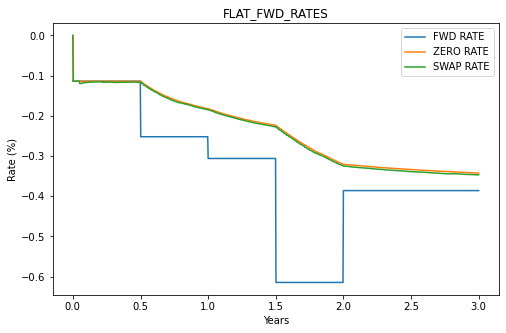

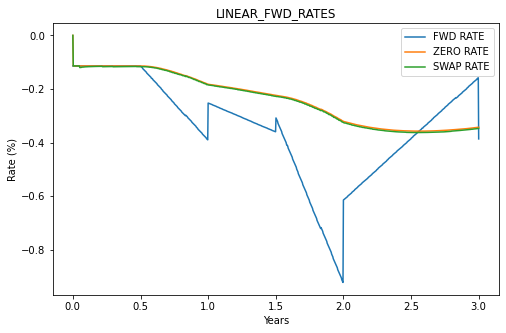

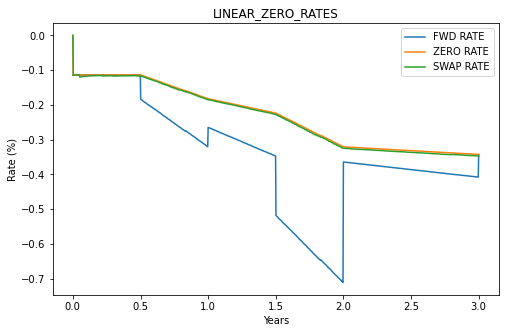

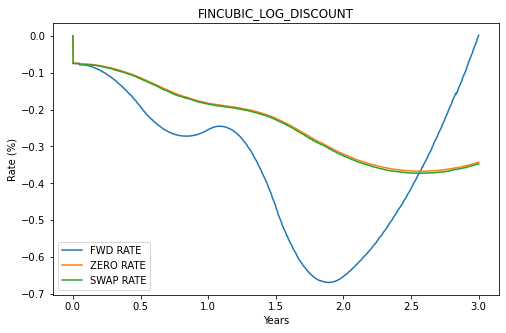

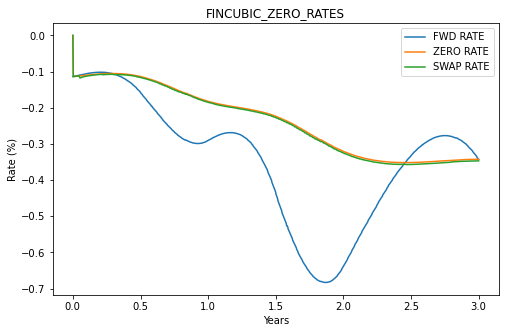

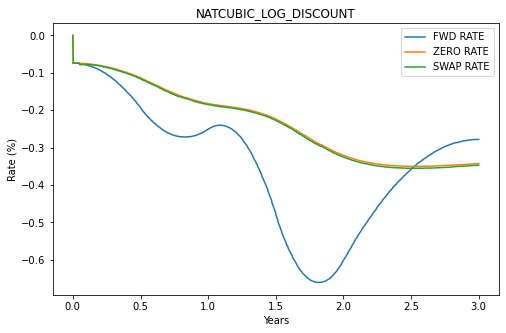

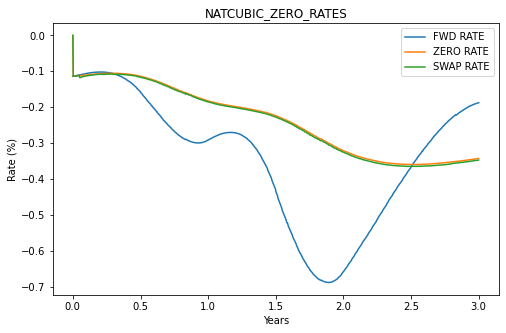

In [25]:
years = np.linspace(0, 3, 1000)
plotDates = settlementDate.addYears(years)

for interpType in TuringInterpTypes:

    plt.figure(figsize=(8,5))
    iborCurve = iborCurves[interpType]
    iborCurveFwdRate = iborCurve.fwdRate(plotDates, "1D")
    iborCurveZeroRate = iborCurve.zeroRate(plotDates)
    iborCurveSwapRate = iborCurve.swapRate(settlementDate, plotDates)
    
    plt.plot(years, iborCurveFwdRate*100.0, label="FWD RATE")
    plt.plot(years, iborCurveZeroRate*100.0, label="ZERO RATE")
    plt.plot(years, iborCurveSwapRate*100.0, label="SWAP RATE")

    plt.title(interpType.name)
    plt.xlabel("Years")
    plt.ylabel("Rate (%)")
    plt.legend();

Copyright (c) Dominic O'Kane 2020